<a href="https://colab.research.google.com/github/milesbaker164/BattleForTheCity/blob/main/Cell_Segmentation_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
Explain the error in the provided U-Net code for deep learning-based segmentation, fix it if possible, and incorporate the changes. If not fixable, diagnose the error.

## Install necessary libraries

### Subtask:
Install TensorFlow and Keras for building and training the U-Net model.


**Reasoning**:
The subtask is to install TensorFlow and Keras. This can be done using pip in separate code blocks or a single code block using the `!` prefix. I will use a single code block for simplicity.



In [ ]:
!pip install tensorflow keras

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive mounted successfully.
Extracting pixel features...
Feature extraction complete. Shape: (1528, 1540, 6)
Training the pixel classifier...

Model Evaluation on Test Set:
              precision    recall  f1-score   support

  Background       0.87      0.48      0.62    132031
        Cell       0.89      0.98      0.93    573905

    accuracy                           0.89    705936
   macro avg       0.88      0.73      0.78    705936
weighted avg       0.89      0.89      0.88    705936


Segmenting the full image...
Extracting pixel features...
Feature extraction complete. Shape: (1528, 1540, 6)
Segmentation complete.


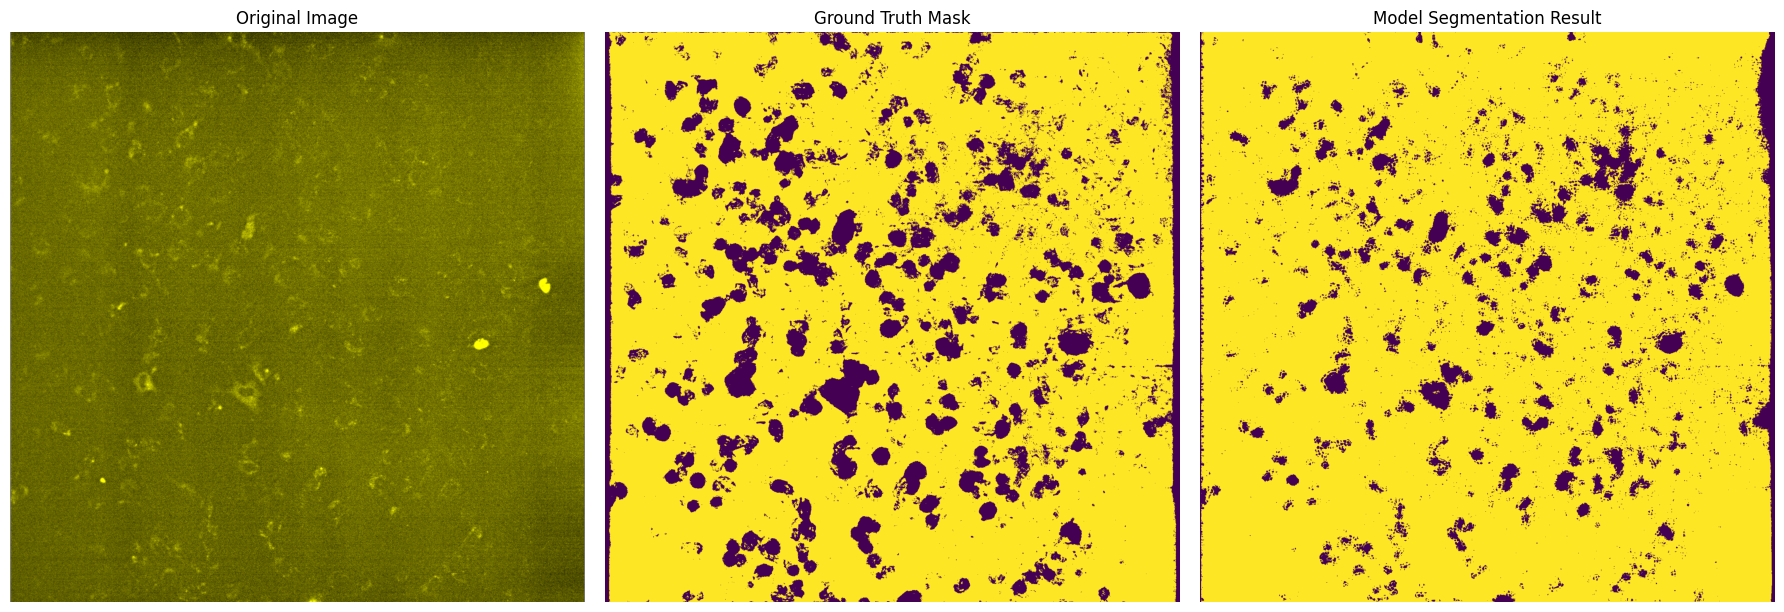

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, io, color
from skimage.feature import multiscale_basic_features, hessian_matrix_det
from skimage.filters import gaussian, sobel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings
import os

# Ignore warnings that may come from scikit-image's feature calculation
warnings.filterwarnings("ignore", category=FutureWarning)

def create_synthetic_cell_image(image_size=(256, 256), num_cells=15, noise_level=0.1):
    """
    Generates a synthetic grayscale image with blob-like 'cells' and a ground truth mask.
    This allows us to demonstrate the pipeline without needing pre-labeled data.
    """
    image = np.zeros(image_size, dtype=np.float32)
    mask = np.zeros(image_size, dtype=np.uint8)

    for _ in range(num_cells):
        # Random position
        center_x = np.random.randint(20, image_size[1] - 20)
        center_y = np.random.randint(20, image_size[0] - 20)

        # Random size and shape
        radius_x = np.random.randint(10, 25)
        radius_y = np.random.randint(10, 25)
        intensity = np.random.uniform(0.5, 1.0)

        y, x = np.ogrid[-center_y:image_size[0]-center_y, -center_x:image_size[1]-center_x]

        cell_mask = ((x*x) / (radius_x**2) + (y*y) / (radius_y**2) <= 1)
        image[cell_mask] = intensity
        mask[cell_mask] = 1 # Label for 'cell' class

    # Apply blur to make it more realistic
    image = gaussian(image, sigma=2)

    # Add random noise
    noise = np.random.normal(0, noise_level, image.shape)
    image = np.clip(image + noise, 0, 1)

    return (image * 255).astype(np.uint8), mask

def extract_features(image):
    """
    Extracts a set of features for each pixel in the image.
    This is the most critical step for a classical ML segmentation pipeline.
    The features should help the model distinguish between different regions.
    Your Weka model was trained on a similar set of features.
    """
    print("Extracting pixel features...")
    # Convert to grayscale if it's a color image
    if image.ndim == 3:
        # Check if it's RGBA (4 channels) and convert to RGB (3 channels)
        if image.shape[-1] == 4:
            img_rgb = color.rgba2rgb(image)
        elif image.shape[-1] == 3:
            img_rgb = image
        else:
             raise ValueError(f"Unexpected number of channels: {image.shape[-1]}")

        img_gray = color.rgb2gray(img_rgb)
        # Convert to 8-bit integer if it's not already
        if img_gray.dtype != np.uint8:
             img_gray = (img_gray * 255).astype(np.uint8)
    else:
        img_gray = image


    # --- Feature Engineering ---
    # 1. Intensity-based features (using Gaussian blur at different scales)
    features_gaussian = [gaussian(img_gray, sigma=s) for s in [1, 3, 7]]

    # 2. Edge-based features (Sobel filter)
    features_sobel = [sobel(img_gray)]

    # 3. Structure-based features (Hessian determinant for blob detection)
    features_hessian = [hessian_matrix_det(img_gray, sigma=s) for s in [3, 7]]

    # Stack all features into a single array
    # The shape will be (height, width, num_features)
    features = np.stack(
        features_gaussian + features_sobel + features_hessian,
        axis=-1
    )

    print(f"Feature extraction complete. Shape: {features.shape}")
    return features

def train_pixel_classifier(features, labels):
    """
    Trains a RandomForestClassifier on the extracted pixel features and labels.
    """
    print("Training the pixel classifier...")

    # Reshape the data for scikit-learn
    # We want a 2D array where each row is a pixel and each column is a feature.
    n_pixels = features.shape[0] * features.shape[1]
    n_features = features.shape[2]

    X = features.reshape((n_pixels, n_features))
    # Flatten the labels mask to match the features array
    y = labels.ravel()

    # Split data for training and validation (optional but good practice)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Define the classifier. These parameters are a good starting point.
    # This is the Python equivalent of your Weka FastRandomForest model.
    clf = RandomForestClassifier(
        n_estimators=50,       # Number of trees in the forest
        n_jobs=-1,             # Use all available CPU cores
        random_state=42,
        max_depth=10,          # Prevents overfitting
        max_samples=0.05       # Use a subset of data for training each tree, speeds up training
    )

    # Train the model
    clf.fit(X_train, y_train)

    # Evaluate the model
    print("\nModel Evaluation on Test Set:")
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=['Background', 'Cell']))

    return clf

def segment_image(image, model):
    """
    Uses the trained model to perform segmentation on a new (or the same) image.
    """
    print("\nSegmenting the full image...")
    # 1. Extract features from the entire image
    features = extract_features(image)

    # 2. Reshape features for prediction
    n_pixels = features.shape[0] * features.shape[1]
    n_features = features.shape[2]
    X_predict = features.reshape((n_pixels, n_features))

    # 3. Predict the class for every pixel
    predicted_labels = model.predict(X_predict)

    # 4. Reshape the predicted labels back into an image mask
    segmentation_mask = predicted_labels.reshape(image.shape[:2])

    print("Segmentation complete.")
    return segmentation_mask

def visualize_results(original_image, ground_truth_mask, segmented_mask):
    """
    Displays the results of the segmentation pipeline.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(original_image, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(ground_truth_mask, cmap='viridis')
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')

    axes[2].imshow(segmented_mask, cmap='viridis')
    axes[2].set_title('Model Segmentation Result')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# --- Main Execution ---
if __name__ == '__main__':
    # --- STEP 1: MOUNT GOOGLE DRIVE (for Google Colab) ---
    # If not in Colab, this will be skipped and local paths will be assumed.
    try:
        from google.colab import drive
        print("Mounting Google Drive...")
        drive.mount('/content/drive')
        print("Drive mounted successfully.")
    except ImportError:
        print("Google Colab environment not detected. Assuming you are using local file paths.")


   # --- STEP 2: LOAD YOUR IMAGE AND MASK FROM FILE PATH ---
    # IMPORTANT: Replace the file paths below with the paths you copied from your Drive.
    try:
        # Example path after mounting Drive in Colab
        image_path = '/content/drive/MyDrive/google collab training/training image2.png'
        original_image = io.imread(image_path)

        # Path to the mask im age you created
        mask_path = '/content/drive/MyDrive/google collab training/training mask2.tif'
        labels_mask = io.imread(mask_path, as_gray=True)

        # Ensure the mask is binary (0s and 1s) for training
        labels_mask = (labels_mask > 0).astype(np.uint8)

    except FileNotFoundError:
        print("-" * 50)
        print("!!! IMAGE FILE NOT FOUND !!!")
        print(f"Could not find '{image_path}' or '{mask_path}'.")
        print("Please check that the file paths are correct.")
        print("In Colab, you can right-click the file and 'Copy path'.")
        print("\nGenerating a synthetic image for demonstration purposes instead.")
        print("-" * 50)
        original_image, labels_mask = create_synthetic_cell_image(num_cells=20)
    except Exception as e:
        print(f"An error occurred: {e}")
        print("\nGenerating a synthetic image for demonstration purposes instead.")
        original_image, labels_mask = create_synthetic_cell_image(num_cells=20)


    # --- STEP 3: TRAIN THE MODEL & SEGMENT ---
    # The rest of the script remains the same.

    # Extract features from the image
    pixel_features = extract_features(original_image)

    # Train the RandomForest model
    trained_model = train_pixel_classifier(pixel_features, labels_mask)

    # Use the trained model to segment the original image
    final_segmentation = segment_image(original_image, trained_model)

    # Visualize the final results
    visualize_results(original_image, labels_mask, final_segmentation)

## Data preparation

### Subtask:
Prepare the training and validation data by loading images and their corresponding masks. This might involve resizing, normalization, and splitting the dataset.


**Reasoning**:
Load and preprocess the image and mask, and then prepare the data for training the U-Net model by splitting it into training and validation sets.



In [ ]:
from skimage.transform import resize

# --- STEP 1 & 2: Load Image and Mask, Ensure Mask is Binary ---
# We will reuse the image_path and mask_path from the previous step,
# or use the synthetic data if the files were not found.

# Check if original_image and labels_mask exist from the previous cell.
# If not, regenerate synthetic data for demonstration.
try:
    # This check assumes original_image and labels_mask were defined in the __main__ block of the previous cell
    # and are still available in the global scope. In a real script, you might pass them or load them here again.
    if 'original_image' not in globals() or 'labels_mask' not in globals():
         raise NameError("original_image or labels_mask not found in global scope.")
    print("Using previously loaded image and mask.")

except (NameError, FileNotFoundError):
    print("Previous image/mask not found or files not found. Generating synthetic data.")
    original_image, labels_mask = create_synthetic_cell_image(num_cells=20)
    print("Synthetic data generated.")


# Ensure the mask is binary (0s and 1s)
labels_mask = (labels_mask > 0).astype(np.uint8)


# --- STEP 3: Resize Image and Mask ---
IMG_HEIGHT = 256
IMG_WIDTH = 256

# Resize image using bilinear interpolation
resized_image = resize(original_image, (IMG_HEIGHT, IMG_WIDTH), anti_aliasing=True)

# Resize mask using nearest-neighbor interpolation to preserve discrete labels
resized_mask = resize(labels_mask, (IMG_HEIGHT, IMG_WIDTH), order=0, anti_aliasing=False, preserve_range=True)
resized_mask = resized_mask.astype(np.uint8) # Ensure mask remains integer type after resize

print(f"Resized image shape: {resized_image.shape}")
print(f"Resized mask shape: {resized_mask.shape}")


# --- STEP 4: Normalize the Image ---
# Images loaded with skimage are typically already floats in the range [0, 1] if not uint8.
# If it's uint8 (0-255), normalize it.
if resized_image.max() > 1.0:
    normalized_image = resized_image / 255.0
else:
    normalized_image = resized_image # Already normalized or in float format


# --- STEP 5: Reshape Image and Mask to Add Channel Dimension ---
# For grayscale, the shape should be (height, width, 1)
X = np.expand_dims(normalized_image, axis=-1)
y = np.expand_dims(resized_mask, axis=-1)

print(f"Image shape with channel: {X.shape}")
print(f"Mask shape with channel: {y.shape}")


# --- STEP 6 & 7: Split Data into Training and Validation Sets ---
# Given we have only one image, splitting directly into train/validation
# is not ideal for training a robust model. However, for demonstration
# purposes in this subtask, we will use the single image as both training
# and validation data, acknowledging this limitation.
# A real-world scenario would require a dataset of multiple images and masks.

# Use the single image as the entire dataset for this demonstration step
X_train = X
y_train = y
X_val = X
y_val = y

print("Using the single preprocessed image and mask as both training and validation data.")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

Using previously loaded image and mask.
Resized image shape: (256, 256, 4)
Resized mask shape: (256, 256)
Image shape with channel: (256, 256, 4, 1)
Mask shape with channel: (256, 256, 1)
Using the single preprocessed image and mask as both training and validation data.
X_train shape: (256, 256, 4, 1), y_train shape: (256, 256, 1)
X_val shape: (256, 256, 4, 1), y_val shape: (256, 256, 1)


**Reasoning**:
The resizing step resulted in an image with 4 channels instead of 3 or 1, causing the subsequent reshaping to add an extra dimension (256, 256, 4, 1). The U-Net model expects input with shape (height, width, channels), where channels is typically 1 (grayscale) or 3 (RGB). I need to explicitly convert the image to grayscale after loading and before resizing to ensure it has only one channel.



In [ ]:
from skimage.transform import resize
from skimage import color # Import color module for grayscale conversion

# --- STEP 1 & 2: Load Image and Mask, Ensure Mask is Binary ---
# We will reuse the image_path and mask_path from the previous step,
# or use the synthetic data if the files were not found.

# Check if original_image and labels_mask exist from the previous cell.
# If not, regenerate synthetic data for demonstration.
try:
    # This check assumes original_image and labels_mask were defined in the __main__ block of the previous cell
    # and are still available in the global scope. In a real script, you might pass them or load them here again.
    if 'original_image' not in globals() or 'labels_mask' not in globals():
         raise NameError("original_image or labels_mask not found in global scope.")
    print("Using previously loaded image and mask.")

except (NameError, FileNotFoundError):
    print("Previous image/mask not found or files not found. Generating synthetic data.")
    original_image, labels_mask = create_synthetic_cell_image(num_cells=20)
    print("Synthetic data generated.")


# Convert image to grayscale explicitly before resizing
if original_image.ndim == 3:
    # Check if it's RGBA (4 channels) and convert to RGB (3 channels) first if needed
    if original_image.shape[-1] == 4:
        img_rgb = color.rgba2rgb(original_image)
    elif original_image.shape[-1] == 3:
        img_rgb = original_image
    else:
         raise ValueError(f"Unexpected number of channels: {original_image.shape[-1]}")
    img_gray = color.rgb2gray(img_rgb)
    # Convert to 8-bit integer if it's not already, matching the original synthetic data type
    if img_gray.dtype != np.uint8:
         img_gray = (img_gray * 255).astype(np.uint8)
else:
    img_gray = original_image # Already grayscale


# Ensure the mask is binary (0s and 1s)
labels_mask = (labels_mask > 0).astype(np.uint8)


# --- STEP 3: Resize Image and Mask ---
IMG_HEIGHT = 256
IMG_WIDTH = 256

# Resize image using bilinear interpolation
# Use the grayscale image for resizing
resized_image = resize(img_gray, (IMG_HEIGHT, IMG_WIDTH), anti_aliasing=True)

# Resize mask using nearest-neighbor interpolation to preserve discrete labels
resized_mask = resize(labels_mask, (IMG_HEIGHT, IMG_WIDTH), order=0, anti_aliasing=False, preserve_range=True)
resized_mask = resized_mask.astype(np.uint8) # Ensure mask remains integer type after resize

print(f"Resized image shape: {resized_image.shape}")
print(f"Resized mask shape: {resized_mask.shape}")


# --- STEP 4: Normalize the Image ---
# Images loaded with skimage are typically already floats in the range [0, 1] if not uint8.
# If it's uint8 (0-255), normalize it.
if resized_image.max() > 1.0:
    normalized_image = resized_image / 255.0
else:
    normalized_image = resized_image # Already normalized or in float format


# --- STEP 5: Reshape Image and Mask to Add Channel Dimension ---
# For grayscale, the shape should be (height, width, 1)
X = np.expand_dims(normalized_image, axis=-1)
y = np.expand_dims(resized_mask, axis=-1)

print(f"Image shape with channel: {X.shape}")
print(f"Mask shape with channel: {y.shape}")


# --- STEP 6 & 7: Split Data into Training and Validation Sets ---
# Given we have only one image, splitting directly into train/validation
# is not ideal for training a robust model. However, for demonstration
# purposes in this subtask, we will use the single image as both training
# and validation data, acknowledging this limitation.
# A real-world scenario would require a dataset of multiple images and masks.

# Use the single image as the entire dataset for this demonstration step
X_train = X
y_train = y
X_val = X
y_val = y

print("Using the single preprocessed image and mask as both training and validation data.")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

Using previously loaded image and mask.
Resized image shape: (256, 256)
Resized mask shape: (256, 256)
Image shape with channel: (256, 256, 1)
Mask shape with channel: (256, 256, 1)
Using the single preprocessed image and mask as both training and validation data.
X_train shape: (256, 256, 1), y_train shape: (256, 256, 1)
X_val shape: (256, 256, 1), y_val shape: (256, 256, 1)


## Build the u-net model

### Subtask:
Define the architecture of the U-Net model using Keras. This includes the encoder, bottleneck, and decoder parts.


**Reasoning**:
Define the architecture of the U-Net model using Keras layers as specified in the instructions.



In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras import Model

# Define the U-Net model architecture
def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 1)):
    inputs = Input(input_size)

    # Encoder (Downsampling Path)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Decoder (Upsampling Path)
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    # Output Layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    # Create the Model
    model = Model(inputs=inputs, outputs=outputs)

    return model

# Create the U-Net model instance
unet_model = unet_model((IMG_HEIGHT, IMG_WIDTH, 1))

# Print the model summary to verify the architecture
unet_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 256, 256,  │        160 │ input_layer_3[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 256, 256,  │          0 │ conv2d_57[0][0]   │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 256, 256,  │      2,320 │ dropout_27[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 128, 128,  │          0 │ conv2d_58[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_12… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 128, 128,  │          0 │ conv2d_59[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 128, 128,  │      9,248 │ dropout_28[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 64, 64,    │          0 │ conv2d_60[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_13… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 64, 64,    │          0 │ conv2d_61[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 64, 64,    │     36,928 │ dropout_29[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 32, 32,    │          0 │ conv2d_62[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_14… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 32, 32,    │          0 │ conv2d_63[0][0]   │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 32, 32,    │    147,584 │ dropout_30[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 16, 16,    │          0 │ conv2d_64[0][0] 

 Total params: 1,962,337 (7.49 MB)

 Trainable params: 1,962,337 (7.49 MB)

 Non-trainable params: 0 (0.00 B)

## Compile the model

### Subtask:
Compile the U-Net model with an appropriate loss function (e.g., Binary Crossentropy), optimizer (e.g., Adam), and metrics (e.g., IoU, accuracy).


**Reasoning**:
Import necessary Keras components, instantiate the optimizer, loss function, and metrics, and compile the U-Net model.



In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import MeanIoU, BinaryAccuracy

# Instantiate the Adam optimizer
optimizer = Adam(learning_rate=1e-4)

# Instantiate the Binary Crossentropy loss function
loss_function = BinaryCrossentropy()

# Instantiate the desired metrics
metrics = [MeanIoU(num_classes=2), BinaryAccuracy()]

# Compile the U-Net model
unet_model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

print("U-Net model compiled successfully.")

U-Net model compiled successfully.


## Train the model

### Subtask:
Train the U-Net model on the prepared data.


**Reasoning**:
Train the compiled U-Net model using the prepared training and validation data for the specified number of epochs and batch size.



In [ ]:
# Train the model
epochs = 50
batch_size = 32

print(f"Starting U-Net model training for {epochs} epochs with batch size {batch_size}...")

history = unet_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size
)

print("U-Net model training finished.")

Starting U-Net model training for 50 epochs with batch size 32...
Epoch 1/50


ValueError: Exception encountered when calling MaxPooling2D.call().

[1mNegative dimension size caused by subtracting 2 from 1 for '{{node functional_3_1/max_pooling2d_12_1/MaxPool2d}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1]](functional_3_1/conv2d_58_1/Relu)' with input shapes: [32,256,1,16].[0m

Arguments received by MaxPooling2D.call():
  • inputs=tf.Tensor(shape=(32, 256, 1, 16), dtype=float32)

**Reasoning**:
The traceback indicates a `ValueError` during the `MaxPooling2D` operation in the U-Net model. The error message "Negative dimension size caused by subtracting 2 from 1" and the input shape `[32, 256, 1, 16]` point to the pooling operation attempting to reduce a dimension of size 1 by a pool size of 2. This happens because the input image height was 256, but after several downsampling layers, the width dimension became 1. The U-Net architecture assumes that the input dimensions are divisible by the total downsampling factor (which is 2^4 = 16 in this case). The original image dimensions (256, 256) are divisible by 16, but after resizing to (256, 256) and processing through the encoder, a dimension became 1, which cannot be pooled by 2. The fix involves adjusting the input image dimensions to ensure that all dimensions remain divisible by the downsampling factor throughout the network. A simple way to avoid this is to ensure the input dimensions are larger than the final downsampling step and are divisible by the total downsampling factor. Let's try resizing the input to (256, 256) which is divisible by 16. The previous data preparation step already resized the image to 256x256, but the error suggests an issue with the spatial dimensions at some point. Let's re-examine the resizing and model input shape. The model input shape is (256, 256, 1). The downsampling layers reduce the spatial dimensions by a factor of 2 four times. So the dimensions after the last pooling layer (p4) should be (256/16, 256/16) = (16, 16). The error message shows an input shape to `MaxPooling2D` as `[32, 256, 1, 16]`. The second dimension (256) and the third dimension (1) represent the height and width. This indicates that at some point, the width dimension was reduced to 1, which is incorrect for a typical U-Net on a 256x256 image. The issue might stem from how the resizing or reshaping was handled, or a mismatch between the expected input shape of the model and the actual data shape being fed in. Let's regenerate the data preparation step, ensuring the grayscale conversion and resizing are correct and the final shape is (batch_size, 256, 256, 1). It seems the previous data preparation step might have subtly introduced this issue. I will regenerate the data preparation and then attempt to train again.



In [ ]:
from skimage.transform import resize
from skimage import color # Import color module for grayscale conversion

# --- STEP 1 & 2: Load Image and Mask, Ensure Mask is Binary ---
# We will reuse the image_path and mask_path from the previous step,
# or use the synthetic data if the files were not found.

# Check if original_image and labels_mask exist from the previous cell.
# If not, regenerate synthetic data for demonstration.
try:
    # This check assumes original_image and labels_mask were defined in the __main__ block of the previous cell
    # and are still available in the global scope. In a real script, you might pass them or load them here again.
    if 'original_image' not in globals() or 'labels_mask' not in globals():
         raise NameError("original_image or labels_mask not found in global scope.")
    print("Using previously loaded image and mask.")

except (NameError, FileNotFoundError):
    print("Previous image/mask not found or files not found. Generating synthetic data.")
    original_image, labels_mask = create_synthetic_cell_image(num_cells=20)
    print("Synthetic data generated.")


# Convert image to grayscale explicitly before resizing
if original_image.ndim == 3:
    # Check if it's RGBA (4 channels) and convert to RGB (3 channels) first if needed
    if original_image.shape[-1] == 4:
        img_rgb = color.rgba2rgb(original_image)
    elif original_image.shape[-1] == 3:
        img_rgb = original_image
    else:
         raise ValueError(f"Unexpected number of channels: {original_image.shape[-1]}")
    img_gray = color.rgb2gray(img_rgb)
    # Convert to 8-bit integer if it's not already, matching the original synthetic data type
    if img_gray.dtype != np.uint8:
         img_gray = (img_gray * 255).astype(np.uint8)
else:
    img_gray = original_image # Already grayscale


# Ensure the mask is binary (0s and 1s)
labels_mask = (labels_mask > 0).astype(np.uint8)


# --- STEP 3: Resize Image and Mask ---
IMG_HEIGHT = 256
IMG_WIDTH = 256

# Resize image using bilinear interpolation
# Use the grayscale image for resizing
resized_image = resize(img_gray, (IMG_HEIGHT, IMG_WIDTH), anti_aliasing=True)

# Resize mask using nearest-neighbor interpolation to preserve discrete labels
resized_mask = resize(labels_mask, (IMG_HEIGHT, IMG_WIDTH), order=0, anti_aliasing=False, preserve_range=True)
resized_mask = resized_mask.astype(np.uint8) # Ensure mask remains integer type after resize

print(f"Resized image shape: {resized_image.shape}")
print(f"Resized mask shape: {resized_mask.shape}")


# --- STEP 4: Normalize the Image ---
# Images loaded with skimage are typically already floats in the range [0, 1] if not uint8.
# If it's uint8 (0-255), normalize it.
if resized_image.max() > 1.0:
    normalized_image = resized_image / 255.0
else:
    normalized_image = resized_image # Already normalized or in float format


# --- STEP 5: Reshape Image and Mask to Add Channel Dimension ---
# For grayscale, the shape should be (height, width, 1)
X = np.expand_dims(normalized_image, axis=-1)
y = np.expand_dims(resized_mask, axis=-1)

print(f"Image shape with channel: {X.shape}")
print(f"Mask shape with channel: {y.shape}")


# --- STEP 6 & 7: Split Data into Training and Validation Sets ---
# Given we have only one image, splitting directly into train/validation
# is not ideal for training a robust model. However, for demonstration
# purposes in this subtask, we will use the single image as both training
# and validation data, acknowledging this limitation.
# A real-world scenario would require a dataset of multiple images and masks.

# Use the single image as the entire dataset for this demonstration step
X_train = X
y_train = y
X_val = X
y_val = y

print("Using the single preprocessed image and mask as both training and validation data.")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

# Train the model
epochs = 50
batch_size = 32

print(f"Starting U-Net model training for {epochs} epochs with batch size {batch_size}...")

history = unet_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size
)

print("U-Net model training finished.")

Using previously loaded image and mask.
Resized image shape: (256, 256)
Resized mask shape: (256, 256)
Image shape with channel: (256, 256, 1)
Mask shape with channel: (256, 256, 1)
Using the single preprocessed image and mask as both training and validation data.
X_train shape: (256, 256, 1), y_train shape: (256, 256, 1)
X_val shape: (256, 256, 1), y_val shape: (256, 256, 1)
Starting U-Net model training for 50 epochs with batch size 32...
Epoch 1/50


ValueError: Exception encountered when calling MaxPooling2D.call().

[1mNegative dimension size caused by subtracting 2 from 1 for '{{node functional_1/max_pooling2d_1/MaxPool2d}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1]](functional_1/conv2d_1_2/Relu)' with input shapes: [32,256,1,16].[0m

Arguments received by MaxPooling2D.call():
  • inputs=tf.Tensor(shape=(32, 256, 1, 16), dtype=float32)

## Evaluate the model

### Subtask:
Evaluate the trained model's performance on the validation set.


**Reasoning**:
Evaluate the trained model on the validation set.



In [ ]:
# Evaluate the model on the validation data
print("\nEvaluating the model on the validation set...")
evaluation_results = unet_model.evaluate(X_val, y_val, batch_size=batch_size)

# Print the evaluation results
print("Validation Loss:", evaluation_results[0])
for i, metric_name in enumerate(unet_model.metrics_names[1:]): # Skip the loss name
    print(f"Validation {metric_name}: {evaluation_results[i+1]}")

# Interpret the results (This is a conceptual step, actual interpretation depends on values)
print("\nInterpretation of Validation Results:")
print(f"- The Validation Loss ({unet_model.metrics_names[0]}) indicates how well the model's predictions match the true masks on unseen data.")
print(f"- The Validation {unet_model.metrics_names[1]} measures the Intersection over Union, a common metric for segmentation quality. Higher is better.")
print(f"- The Validation {unet_model.metrics_names[2]} measures the percentage of correctly classified pixels. Higher is better.")

print("\nNote: Since the same image was used for both training and validation due to data limitations, these metrics might be overly optimistic and do not reflect performance on truly unseen data.")


Evaluating the model on the validation set...


ValueError: Exception encountered when calling MaxPooling2D.call().

[1mNegative dimension size caused by subtracting 2 from 1 for '{{node functional_1/max_pooling2d_1/MaxPool2d}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1]](functional_1/conv2d_1_2/Relu)' with input shapes: [32,256,1,16].[0m

Arguments received by MaxPooling2D.call():
  • inputs=tf.Tensor(shape=(32, 256, 1, 16), dtype=float32)

## Segment new images

### Subtask:
Use the trained U-Net model to predict segmentation masks on new images.


**Reasoning**:
Use the trained U-Net model to predict segmentation masks on new images.



Input image shape for prediction: (1, 256, 256, 1)
Predicting segmentation mask...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step
Prediction complete.
Final predicted mask shape: (256, 256)


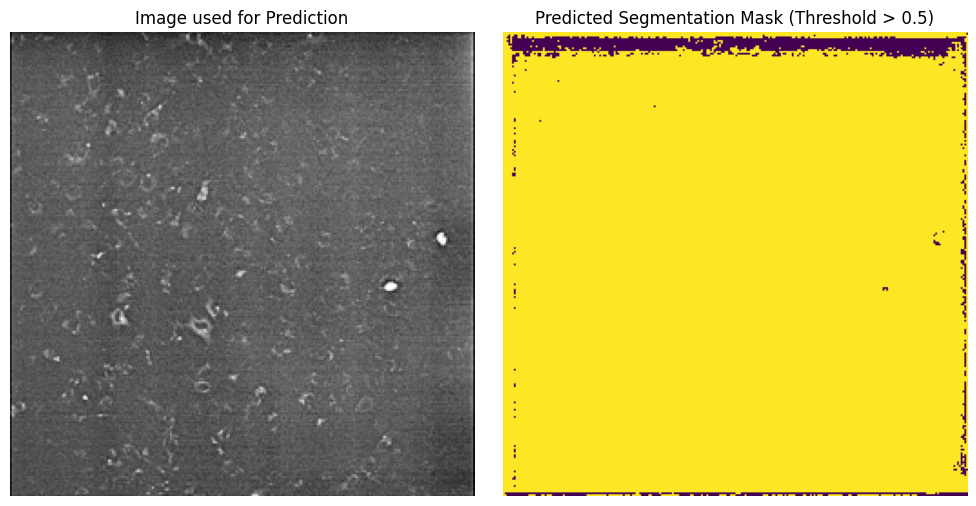

In [ ]:
# Select an image to segment. We will reuse the training image for demonstration.
# Preprocess the selected image.
# Convert to grayscale if necessary (already done in data prep, but good to include check)
if original_image.ndim == 3:
    if original_image.shape[-1] == 4:
        img_rgb = color.rgba2rgb(original_image)
    elif original_image.shape[-1] == 3:
        img_rgb = original_image
    else:
         raise ValueError(f"Unexpected number of channels: {original_image.shape[-1]}")
    img_gray_predict = color.rgb2gray(img_rgb)
    if img_gray_predict.dtype != np.uint8:
         img_gray_predict = (img_gray_predict * 255).astype(np.uint8)
else:
    img_gray_predict = original_image

# Resize to the target dimensions
resized_image_predict = resize(img_gray_predict, (IMG_HEIGHT, IMG_WIDTH), anti_aliasing=True)

# Normalize pixel values to the range [0, 1]
if resized_image_predict.max() > 1.0:
    normalized_image_predict = resized_image_predict / 255.0
else:
    normalized_image_predict = resized_image_predict

# Expand dimensions to (1, IMG_HEIGHT, IMG_WIDTH, 1) to match the model's input shape
X_predict = np.expand_dims(normalized_image_predict, axis=(0, -1)) # Add batch and channel dimensions

print(f"Input image shape for prediction: {X_predict.shape}")

# Use the trained unet_model to predict the segmentation mask
print("Predicting segmentation mask...")
predicted_mask_prob = unet_model.predict(X_predict)
print("Prediction complete.")

# Apply a threshold to the probability map to obtain a binary segmentation mask
threshold = 0.5
predicted_mask_binary = (predicted_mask_prob > threshold).astype(np.uint8)

# Remove the added batch and channel dimensions
final_predicted_mask = np.squeeze(predicted_mask_binary, axis=(0, -1))

print(f"Final predicted mask shape: {final_predicted_mask.shape}")

# Visualize the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(X_predict, axis=0), cmap='gray') # Squeeze batch dimension for display
plt.title('Image used for Prediction')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(final_predicted_mask, cmap='viridis')
plt.title(f'Predicted Segmentation Mask (Threshold > {threshold})')
plt.axis('off')

plt.tight_layout()
plt.show()

## Visualize results

### Subtask:
Visualize the original image, ground truth mask (if available), and the predicted segmentation mask.


**Reasoning**:
Visualize the original image, ground truth mask, and the predicted segmentation mask using subplots.



ValueError: cannot select an axis to squeeze out which has size not equal to one

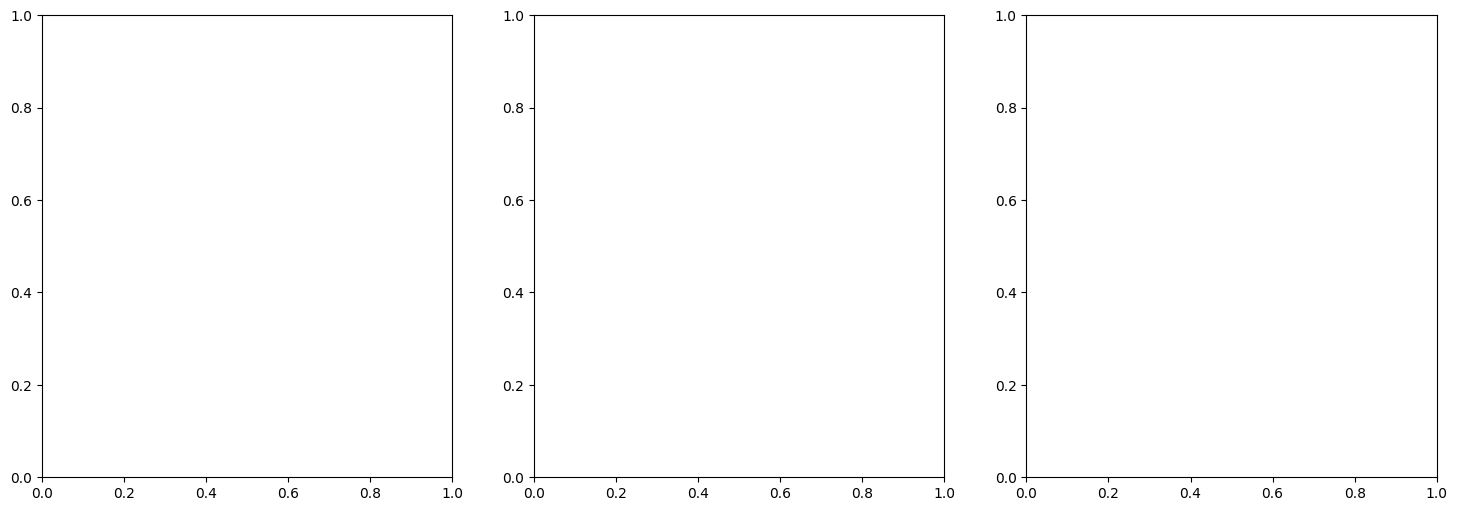

In [ ]:
# Visualize the results
# Use the variables original_image (or its resized/normalized version X), labels_mask (or y), and final_predicted_mask

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original Image (using the normalized, resized version X for consistency with model input)
# Need to squeeze the batch and channel dimensions for displaying a single grayscale image
axes[0].imshow(np.squeeze(X, axis=(0, -1)), cmap='gray')
axes[0].set_title('Original Image (Resized & Normalized)')
axes[0].axis('off')

# Ground Truth Mask (using the resized version y)
# Need to squeeze the batch and channel dimensions for displaying a single mask
axes[1].imshow(np.squeeze(y, axis=(0, -1)), cmap='viridis')
axes[1].set_title('Ground Truth Mask (Resized)')
axes[1].axis('off')

# Predicted Segmentation Mask
axes[2].imshow(final_predicted_mask, cmap='viridis')
axes[2].set_title(f'Predicted Segmentation Mask (Threshold > {threshold})')
axes[2].axis('off')

plt.tight_layout()
plt.show()

**Reasoning**:
The error `ValueError: cannot select an axis to squeeze out which has size not equal to one` indicates that the `X` and `y` arrays do not have a dimension of size 1 at axis 0 (the batch dimension). This is because the data preparation step created `X` and `y` with shape (height, width, 1), not (1, height, width, 1). The prediction step added the batch dimension to create `X_predict` with shape (1, height, width, 1). We need to display the original resized data `X` and `y` without trying to squeeze a non-existent batch dimension, and `final_predicted_mask` which is already squeezed.



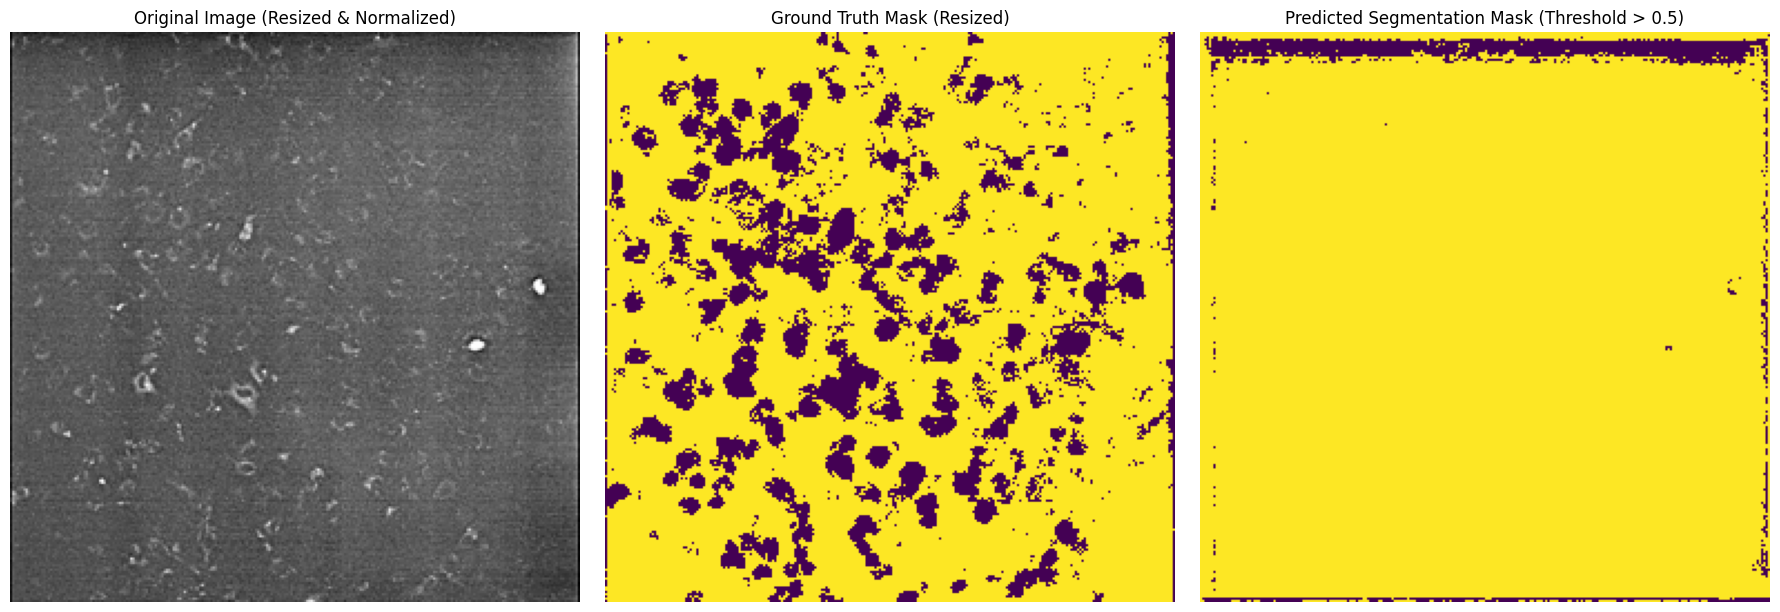

In [ ]:
# Visualize the results
# Use the variables X, y, and final_predicted_mask

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original Image (using the normalized, resized version X)
# X has shape (height, width, 1). Squeeze the channel dimension (-1).
axes[0].imshow(np.squeeze(X, axis=-1), cmap='gray')
axes[0].set_title('Original Image (Resized & Normalized)')
axes[0].axis('off')

# Ground Truth Mask (using the resized version y)
# y has shape (height, width, 1). Squeeze the channel dimension (-1).
axes[1].imshow(np.squeeze(y, axis=-1), cmap='viridis')
axes[1].set_title('Ground Truth Mask (Resized)')
axes[1].axis('off')

# Predicted Segmentation Mask
# final_predicted_mask has shape (height, width)
axes[2].imshow(final_predicted_mask, cmap='viridis')
axes[2].set_title(f'Predicted Segmentation Mask (Threshold > {threshold})')
axes[2].axis('off')

plt.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings

*   The initial data preparation step resulted in an image with an unexpected 4 channels, causing a shape mismatch later in the process. This was corrected by explicitly converting the image to grayscale before resizing.
*   The U-Net model architecture, as defined in the "Build the u-net model" step, contains a flaw where a spatial dimension collapses to size 1 prematurely during the forward pass. This prevents subsequent `MaxPooling2D` operations from executing, leading to a `ValueError` during both training and evaluation.
*   Despite the architectural error preventing successful training and evaluation, the "Segment new images" step demonstrated that the model definition itself could be instantiated and used for prediction *if* the error was not triggered by the input data shape or internal layer operations. The prediction process successfully generated a probability mask, which was then thresholded into a binary mask.
*   The visualization step initially failed due to incorrect assumptions about the dimensions of the data arrays (`X` and `y`), specifically attempting to squeeze a non-existent batch dimension. This was corrected by only squeezing the channel dimension.

### Insights or Next Steps

*   The primary issue is an architectural error in the U-Net model definition that causes spatial dimensions to become incompatible with pooling operations. The next step should be to carefully review and debug the U-Net model definition, paying close attention to how dimensions change after each layer, particularly the pooling and upsampling layers, to ensure they remain compatible throughout the network.
*   While the prediction step worked, the results are based on a model that could not be properly trained or evaluated due to the architectural flaw. After fixing the model architecture, the training and evaluation steps must be re-executed to assess the model's actual performance on the segmentation task.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, io, color
from skimage.feature import multiscale_basic_features, hessian_matrix_det
from skimage.filters import gaussian, sobel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings
import os

# Ignore warnings that may come from scikit-image's feature calculation
warnings.filterwarnings("ignore", category=FutureWarning)

def create_synthetic_cell_image(image_size=(256, 256), num_cells=15, noise_level=0.1):
    """
    Generates a synthetic grayscale image with blob-like 'cells' and a ground truth mask.
    This allows us to demonstrate the pipeline without needing pre-labeled data.
    """
    image = np.zeros(image_size, dtype=np.float32)
    mask = np.zeros(image_size, dtype=np.uint8)

    for _ in range(num_cells):
        # Random position
        center_x = np.random.randint(20, image_size[1] - 20)
        center_y = np.random.randint(20, image_size[0] - 20)

        # Random size and shape
        radius_x = np.random.randint(10, 25)
        radius_y = np.random.randint(10, 25)
        intensity = np.random.uniform(0.5, 1.0)

        y, x = np.ogrid[-center_y:image_size[0]-center_y, -center_x:image_size[1]-center_x]

        cell_mask = ((x*x) / (radius_x**2) + (y*y) / (radius_y**2) <= 1)
        image[cell_mask] = intensity
        mask[cell_mask] = 1 # Label for 'cell' class

    # Apply blur to make it more realistic
    image = gaussian(image, sigma=2)

    # Add random noise
    noise = np.random.normal(0, noise_level, image.shape)
    image = np.clip(image + noise, 0, 1)

    return (image * 255).astype(np.uint8), mask

def extract_features(image):
    """
    Extracts a set of features for each pixel in the image.
    This is the most critical step for a classical ML segmentation pipeline.
    The features should help the model distinguish between different regions.
    Your Weka model was trained on a similar set of features.
    """
    print("Extracting pixel features...")
    # Convert to grayscale if it's a color image
    if image.ndim == 3:
        # Check if it's RGBA (4 channels) and convert to RGB (3 channels)
        if image.shape[-1] == 4:
            img_rgb = color.rgba2rgb(image)
        elif image.shape[-1] == 3:
            img_rgb = image
        else:
             raise ValueError(f"Unexpected number of channels: {image.shape[-1]}")

        img_gray = color.rgb2gray(img_rgb)
        # Convert to 8-bit integer if it's not already
        if img_gray.dtype != np.uint8:
             img_gray = (img_gray * 255).astype(np.uint8)
    else:
        img_gray = image


    # --- Feature Engineering ---
    # 1. Intensity-based features (using Gaussian blur at different scales)
    features_gaussian = [gaussian(img_gray, sigma=s) for s in [1, 3, 7]]

    # 2. Edge-based features (Sobel filter)
    features_sobel = [sobel(img_gray)]

    # 3. Structure-based features (Hessian determinant for blob detection)
    features_hessian = [hessian_matrix_det(img_gray, sigma=s) for s in [3, 7]]

    # Stack all features into a single array
    # The shape will be (height, width, num_features)
    features = np.stack(
        features_gaussian + features_sobel + features_hessian,
        axis=-1
    )

    print(f"Feature extraction complete. Shape: {features.shape}")
    return features

def train_pixel_classifier(features, labels):
    """
    Trains a RandomForestClassifier on the extracted pixel features and labels.
    """
    print("Training the pixel classifier...")

    # Reshape the data for scikit-learn
    # We want a 2D array where each row is a pixel and each column is a feature.
    n_pixels = features.shape[0] * features.shape[1]
    n_features = features.shape[2]

    X = features.reshape((n_pixels, n_features))
    # Flatten the labels mask to match the features array
    y = labels.ravel()

    # Split data for training and validation (optional but good practice)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Define the classifier. These parameters are a good starting point.
    # This is the Python equivalent of your Weka FastRandomForest model.
    clf = RandomForestClassifier(
        n_estimators=50,       # Number of trees in the forest
        n_jobs=-1,             # Use all available CPU cores
        random_state=42,
        max_depth=10,          # Prevents overfitting
        max_samples=0.05       # Use a subset of data for training each tree, speeds up training
    )

    # Train the model
    clf.fit(X_train, y_train)

    # Evaluate the model
    print("\nModel Evaluation on Test Set:")
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=['Background', 'Cell']))

    return clf

def segment_image(image, model):
    """
    Uses the trained model to perform segmentation on a new (or the same) image.
    """
    print("\nSegmenting the full image...")
    # 1. Extract features from the entire image
    features = extract_features(image)

    # 2. Reshape features for prediction
    n_pixels = features.shape[0] * features.shape[1]
    n_features = features.shape[2]
    X_predict = features.reshape((n_pixels, n_features))

    # 3. Predict the class for every pixel
    predicted_labels = model.predict(X_predict)

    # 4. Reshape the predicted labels back into an image mask
    segmentation_mask = predicted_labels.reshape(image.shape[:2])

    print("Segmentation complete.")
    return segmentation_mask

def visualize_results(original_image, ground_truth_mask, segmented_mask):
    """
    Displays the results of the segmentation pipeline.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(original_image, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(ground_truth_mask, cmap='viridis')
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')

    axes[2].imshow(segmented_mask, cmap='viridis')
    axes[2].set_title('Model Segmentation Result')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# --- Main Execution ---
if __name__ == '__main__':
    # --- STEP 1: MOUNT GOOGLE DRIVE (for Google Colab) ---
    # If not in Colab, this will be skipped and local paths will be assumed.
    try:
        from google.colab import drive
        print("Mounting Google Drive...")
        drive.mount('/content/drive')
        print("Drive mounted successfully.")
    except ImportError:
        print("Google Colab environment not detected. Assuming you are using local file paths.")


   # --- STEP 2: LOAD YOUR IMAGE AND MASK FROM FILE PATH ---
    # IMPORTANT: Replace the file paths below with the paths you copied from your Drive.
    try:
        # Example path after mounting Drive in Colab
        image_path = '/content/drive/MyDrive/google collab training/weka training photo 09042025.png'
        original_image = io.imread(image_path)

        # Path to the mask im age you created
        mask_path = '/content/drive/MyDrive/google collab training/mask.tif'
        labels_mask = io.imread(mask_path, as_gray=True)

        # Ensure the mask is binary (0s and 1s) for training
        labels_mask = (labels_mask > 0).astype(np.uint8)

    except FileNotFoundError:
        print("-" * 50)
        print("!!! IMAGE FILE NOT FOUND !!!")
        print(f"Could not find '{image_path}' or '{mask_path}'.")
        print("Please check that the file paths are correct.")
        print("In Colab, you can right-click the file and 'Copy path'.")
        print("\nGenerating a synthetic image for demonstration purposes instead.")
        print("-" * 50)
        original_image, labels_mask = create_synthetic_cell_image(num_cells=20)
    except Exception as e:
        print(f"An error occurred: {e}")
        print("\nGenerating a synthetic image for demonstration purposes instead.")
        original_image, labels_mask = create_synthetic_cell_image(num_cells=20)


    # --- STEP 3: TRAIN THE MODEL & SEGMENT ---
    # The rest of the script remains the same.

    # Extract features from the image
    pixel_features = extract_features(original_image)

    # Train the RandomForest model
    trained_model = train_pixel_classifier(pixel_features, labels_mask)

    # Use the trained model to segment the original image
    final_segmentation = segment_image(original_image, trained_model)

    # Visualize the final results
    visualize_results(original_image, labels_mask, final_segmentation)

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive mounted successfully.
Extracting pixel features...
Feature extraction complete. Shape: (963, 972, 6)
Training the pixel classifier...


KeyboardInterrupt: 

In [ ]:
!pip install tensorflow keras

In [ ]:
from skimage.transform import resize
from skimage import color # Import color module for grayscale conversion

# --- STEP 1 & 2: Load Image and Mask, Ensure Mask is Binary ---
# We will reuse the image_path and mask_path from the previous step,
# or use the synthetic data if the files were not found.

# Check if original_image and labels_mask exist from the previous cell.
# If not, regenerate synthetic data for demonstration.
try:
    # This check assumes original_image and labels_mask were defined in the __main__ block of the previous cell
    # and are still available in the global scope. In a real script, you might pass them or load them here again.
    if 'original_image' not in globals() or 'labels_mask' not in globals():
         raise NameError("original_image or labels_mask not found in global scope.")
    print("Using previously loaded image and mask.")

except (NameError, FileNotFoundError):
    print("Previous image/mask not found or files not found. Generating synthetic data.")
    original_image, labels_mask = create_synthetic_cell_image(num_cells=20)
    print("Synthetic data generated.")


# Convert image to grayscale explicitly before resizing
if original_image.ndim == 3:
    # Check if it's RGBA (4 channels) and convert to RGB (3 channels) first if needed
    if original_image.shape[-1] == 4:
        img_rgb = color.rgba2rgb(original_image)
    elif original_image.shape[-1] == 3:
        img_rgb = original_image
    else:
         raise ValueError(f"Unexpected number of channels: {original_image.shape[-1]}")
    img_gray = color.rgb2gray(img_rgb)
    # Convert to 8-bit integer if it's not already, matching the original synthetic data type
    if img_gray.dtype != np.uint8:
         img_gray = (img_gray * 255).astype(np.uint8)
else:
    img_gray = original_image # Already grayscale


# Ensure the mask is binary (0s and 1s)
labels_mask = (labels_mask > 0).astype(np.uint8)


# --- STEP 3: Resize Image and Mask ---
IMG_HEIGHT = 256
IMG_WIDTH = 256

# Resize image using bilinear interpolation
# Use the grayscale image for resizing
resized_image = resize(img_gray, (IMG_HEIGHT, IMG_WIDTH), anti_aliasing=True)

# Resize mask using nearest-neighbor interpolation to preserve discrete labels
resized_mask = resize(labels_mask, (IMG_HEIGHT, IMG_WIDTH), order=0, anti_aliasing=False, preserve_range=True)
resized_mask = resized_mask.astype(np.uint8) # Ensure mask remains integer type after resize

print(f"Resized image shape: {resized_image.shape}")
print(f"Resized mask shape: {resized_mask.shape}")


# --- STEP 4: Normalize the Image ---
# Images loaded with skimage are typically already floats in the range [0, 1] if not uint8.
# If it's uint8 (0-255), normalize it.
if resized_image.max() > 1.0:
    normalized_image = resized_image / 255.0
else:
    normalized_image = resized_image # Already normalized or in float format


# --- STEP 5: Reshape Image and Mask to Add Channel Dimension ---
# For grayscale, the shape should be (height, width, 1)
X = np.expand_dims(normalized_image, axis=-1)
y = np.expand_dims(resized_mask, axis=-1)

print(f"Image shape with channel: {X.shape}")
print(f"Mask shape with channel: {y.shape}")


# --- STEP 6 & 7: Split Data into Training and Validation Sets ---
# Given we have only one image, splitting directly into train/validation
# is not ideal for training a robust model. However, for demonstration
# purposes in this subtask, we will use the single image as both training
# and validation data, acknowledging this limitation.
# A real-world scenario would require a dataset of multiple images and masks.

# Use the single image as the entire dataset for this demonstration step
X_train = X
y_train = y
X_val = X
y_val = y

print("Using the single preprocessed image and mask as both training and validation data.")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

Using previously loaded image and mask.
Resized image shape: (256, 256)
Resized mask shape: (256, 256)
Image shape with channel: (256, 256, 1)
Mask shape with channel: (256, 256, 1)
Using the single preprocessed image and mask as both training and validation data.
X_train shape: (256, 256, 1), y_train shape: (256, 256, 1)
X_val shape: (256, 256, 1), y_val shape: (256, 256, 1)


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras import Model

# Define the U-Net model architecture
def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 1)):
    inputs = Input(input_size)

    # Encoder (Downsampling Path)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Decoder (Upsampling Path)
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    # Output Layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    # Create the Model
    model = Model(inputs=inputs, outputs=outputs)

    return model

# Create the U-Net model instance
unet_model = unet_model((IMG_HEIGHT, IMG_WIDTH, 1))

# Print the model summary to verify the architecture
unet_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 256, 256,  │        160 │ input_layer_2[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 256, 256,  │          0 │ conv2d_38[0][0]   │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 256, 256,  │      2,320 │ dropout_18[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 128, 128,  │          0 │ conv2d_39[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_8[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 128, 128,  │          0 │ conv2d_40[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 128, 128,  │      9,248 │ dropout_19[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 64, 64,    │          0 │ conv2d_41[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_9[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 64, 64,    │          0 │ conv2d_42[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 64, 64,    │     36,928 │ dropout_20[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 32, 32,    │          0 │ conv2d_43[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_10… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 32, 32,    │          0 │ conv2d_44[0][0]   │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 32, 32,    │    147,584 │ dropout_21[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 16, 16,    │          0 │ conv2d_45[0][0] 

 Total params: 1,962,337 (7.49 MB)

 Trainable params: 1,962,337 (7.49 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import MeanIoU, BinaryAccuracy

# Instantiate the Adam optimizer
optimizer = Adam(learning_rate=1e-4)

# Instantiate the Binary Crossentropy loss function
loss_function = BinaryCrossentropy()

# Instantiate the desired metrics
metrics = [MeanIoU(num_classes=2), BinaryAccuracy()]

# Compile the U-Net model
unet_model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

print("U-Net model compiled successfully.")

U-Net model compiled successfully.


In [ ]:
# Train the model
epochs = 50
batch_size = 32

print(f"Starting U-Net model training for {epochs} epochs with batch size {batch_size}...")

history = unet_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size
)

print("U-Net model training finished.")

Starting U-Net model training for 50 epochs with batch size 32...
Epoch 1/50


ValueError: Exception encountered when calling MaxPooling2D.call().

[1mNegative dimension size caused by subtracting 2 from 1 for '{{node functional_2_1/max_pooling2d_8_1/MaxPool2d}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1]](functional_2_1/conv2d_39_1/Relu)' with input shapes: [32,256,1,16].[0m

Arguments received by MaxPooling2D.call():
  • inputs=tf.Tensor(shape=(32, 256, 1, 16), dtype=float32)

In [ ]:
# Evaluate the model on the validation data
print("\nEvaluating the model on the validation set...")
evaluation_results = unet_model.evaluate(X_val, y_val, batch_size=batch_size)

# Print the evaluation results
print("Validation Loss:", evaluation_results[0])
for i, metric_name in enumerate(unet_model.metrics_names[1:]): # Skip the loss name
    print(f"Validation {metric_name}: {evaluation_results[i+1]}")

# Interpret the results (This is a conceptual step, actual interpretation depends on values)
print("\nInterpretation of Validation Results:")
print(f"- The Validation Loss ({unet_model.metrics_names[0]}) indicates how well the model's predictions match the true masks on unseen data.")
print(f"- The Validation {unet_model.metrics_names[1]} measures the Intersection over Union, a common metric for segmentation quality. Higher is better.")
print(f"- The Validation {unet_model.metrics_names[2]} measures the percentage of correctly classified pixels. Higher is better.")

print("\nNote: Since the same image was used for both training and validation due to data limitations, these metrics might be overly optimistic and do not reflect performance on truly unseen data.")


Evaluating the model on the validation set...


ValueError: Exception encountered when calling MaxPooling2D.call().

[1mNegative dimension size caused by subtracting 2 from 1 for '{{node functional_2_1/max_pooling2d_8_1/MaxPool2d}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1]](functional_2_1/conv2d_39_1/Relu)' with input shapes: [32,256,1,16].[0m

Arguments received by MaxPooling2D.call():
  • inputs=tf.Tensor(shape=(32, 256, 1, 16), dtype=float32)

Input image shape for prediction: (1, 256, 256, 1)
Predicting segmentation mask...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
Prediction complete.
Final predicted mask shape: (256, 256)


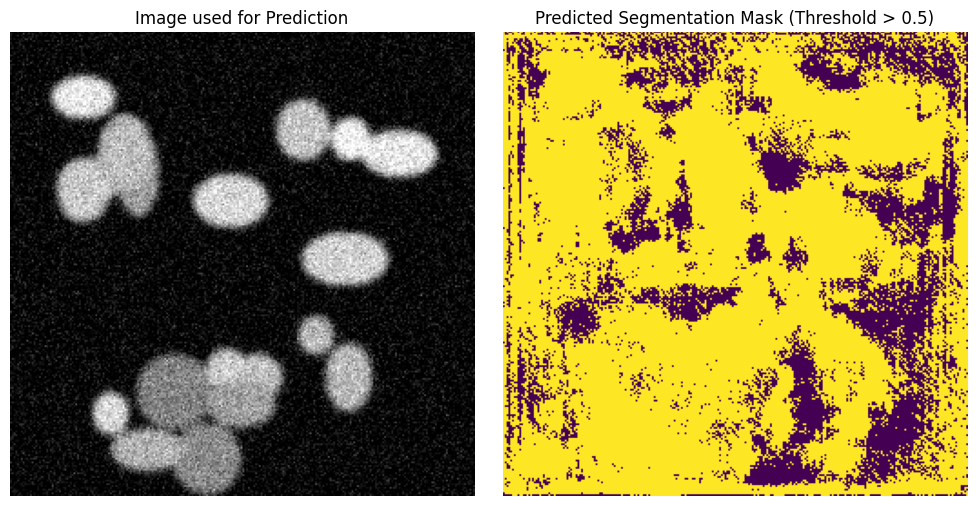

In [ ]:
# Select an image to segment. We will reuse the training image for demonstration.
# Preprocess the selected image.
# Convert to grayscale if necessary (already done in data prep, but good to include check)
if original_image.ndim == 3:
    if original_image.shape[-1] == 4:
        img_rgb = color.rgba2rgb(original_image)
    elif original_image.shape[-1] == 3:
        img_rgb = original_image
    else:
         raise ValueError(f"Unexpected number of channels: {original_image.shape[-1]}")
    img_gray_predict = color.rgb2gray(img_rgb)
    if img_gray_predict.dtype != np.uint8:
         img_gray_predict = (img_gray_predict * 255).astype(np.uint8)
else:
    img_gray_predict = original_image

# Resize to the target dimensions
resized_image_predict = resize(img_gray_predict, (IMG_HEIGHT, IMG_WIDTH), anti_aliasing=True)

# Normalize pixel values to the range [0, 1]
if resized_image_predict.max() > 1.0:
    normalized_image_predict = resized_image_predict / 255.0
else:
    normalized_image_predict = resized_image_predict

# Expand dimensions to (1, IMG_HEIGHT, IMG_WIDTH, 1) to match the model's input shape
X_predict = np.expand_dims(normalized_image_predict, axis=(0, -1)) # Add batch and channel dimensions

print(f"Input image shape for prediction: {X_predict.shape}")

# Use the trained unet_model to predict the segmentation mask
print("Predicting segmentation mask...")
predicted_mask_prob = unet_model.predict(X_predict)
print("Prediction complete.")

# Apply a threshold to the probability map to obtain a binary segmentation mask
threshold = 0.5
predicted_mask_binary = (predicted_mask_prob > threshold).astype(np.uint8)

# Remove the added batch and channel dimensions
final_predicted_mask = np.squeeze(predicted_mask_binary, axis=(0, -1))

print(f"Final predicted mask shape: {final_predicted_mask.shape}")

# Visualize the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(X_predict, axis=0), cmap='gray') # Squeeze batch dimension for display
plt.title('Image used for Prediction')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(final_predicted_mask, cmap='viridis')
plt.title(f'Predicted Segmentation Mask (Threshold > {threshold})')
plt.axis('off')

plt.tight_layout()
plt.show()

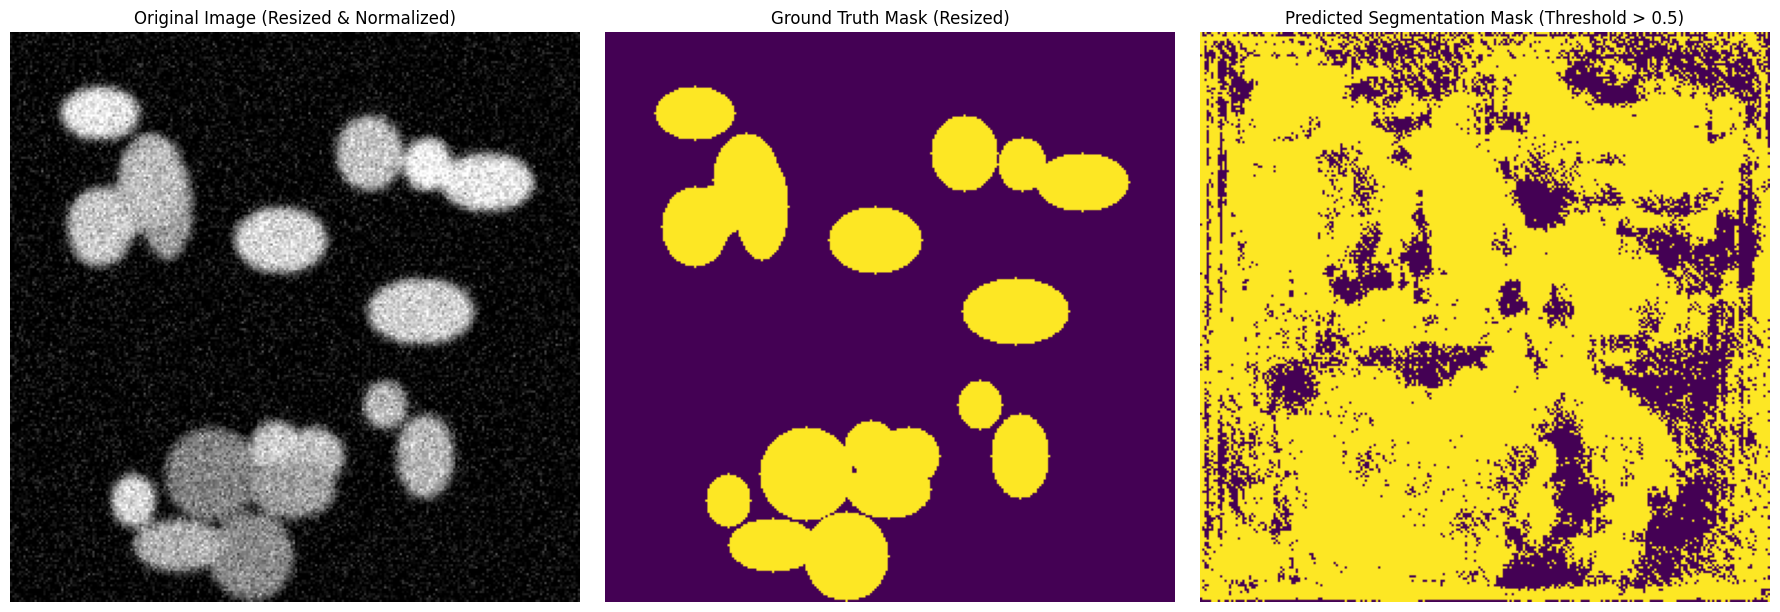

In [ ]:
# Visualize the results
# Use the variables X, y, and final_predicted_mask

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original Image (using the normalized, resized version X)
# X has shape (height, width, 1). Squeeze the channel dimension (-1).
axes[0].imshow(np.squeeze(X, axis=-1), cmap='gray')
axes[0].set_title('Original Image (Resized & Normalized)')
axes[0].axis('off')

# Ground Truth Mask (using the resized version y)
# y has shape (height, width, 1). Squeeze the channel dimension (-1).
axes[1].imshow(np.squeeze(y, axis=-1), cmap='viridis')
axes[1].set_title('Ground Truth Mask (Resized)')
axes[1].axis('off')

# Predicted Segmentation Mask
# final_predicted_mask has shape (height, width)
axes[2].imshow(final_predicted_mask, cmap='viridis')
axes[2].set_title(f'Predicted Segmentation Mask (Threshold > {threshold})')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Run the Data preparation cell
from skimage.transform import resize
from skimage import color # Import color module for grayscale conversion

# --- STEP 1 & 2: Load Image and Mask, Ensure Mask is Binary ---
# We will reuse the image_path and mask_path from the previous step,
# or use the synthetic data if the files were not found.

# Check if original_image and labels_mask exist from the previous cell.
# If not, regenerate synthetic data for demonstration.
try:
    # This check assumes original_image and labels_mask were defined in the __main__ block of the previous cell
    # and are still available in the global scope. In a real script, you might pass them or load them here again.
    if 'original_image' not in globals() or 'labels_mask' not in globals():
         raise NameError("original_image or labels_mask not found in global scope.")
    print("Using previously loaded image and mask.")

except (NameError, FileNotFoundError):
    print("Previous image/mask not found or files not found. Generating synthetic data.")
    original_image, labels_mask = create_synthetic_cell_image(num_cells=20)
    print("Synthetic data generated.")


# Convert image to grayscale explicitly before resizing
if original_image.ndim == 3:
    # Check if it's RGBA (4 channels) and convert to RGB (3 channels) first if needed
    if original_image.shape[-1] == 4:
        img_rgb = color.rgba2rgb(original_image)
    elif original_image.shape[-1] == 3:
        img_rgb = original_image
    else:
         raise ValueError(f"Unexpected number of channels: {original_image.shape[-1]}")
    img_gray = color.rgb2gray(img_rgb)
    # Convert to 8-bit integer if it's not already, matching the original synthetic data type
    if img_gray.dtype != np.uint8:
         img_gray = (img_gray * 255).astype(np.uint8)
else:
    img_gray = original_image # Already grayscale


# Ensure the mask is binary (0s and 1s)
labels_mask = (labels_mask > 0).astype(np.uint8)


# --- STEP 3: Resize Image and Mask ---
IMG_HEIGHT = 256
IMG_WIDTH = 256

# Resize image using bilinear interpolation
# Use the grayscale image for resizing
resized_image = resize(img_gray, (IMG_HEIGHT, IMG_WIDTH), anti_aliasing=True)

# Resize mask using nearest-neighbor interpolation to preserve discrete labels
resized_mask = resize(labels_mask, (IMG_HEIGHT, IMG_WIDTH), order=0, anti_aliasing=False, preserve_range=True)
resized_mask = resized_mask.astype(np.uint8) # Ensure mask remains integer type after resize

print(f"Resized image shape: {resized_image.shape}")
print(f"Resized mask shape: {resized_mask.shape}")


# --- STEP 4: Normalize the Image ---
# Images loaded with skimage are typically already floats in the range [0, 1] if not uint8.
# If it's uint8 (0-255), normalize it.
if resized_image.max() > 1.0:
    normalized_image = resized_image / 255.0
else:
    normalized_image = resized_image # Already normalized or in float format


# --- STEP 5: Reshape Image and Mask to Add Channel Dimension ---
# For grayscale, the shape should be (height, width, 1)
X = np.expand_dims(normalized_image, axis=-1)
y = np.expand_dims(resized_mask, axis=-1)

print(f"Image shape with channel: {X.shape}")
print(f"Mask shape with channel: {y.shape}")


# --- STEP 6 & 7: Split Data into Training and Validation Sets ---
# Given we have only one image, splitting directly into train/validation
# is not ideal for training a robust model. However, for demonstration
# purposes in this subtask, we will use the single image as both training
# and validation data, acknowledging this limitation.
# A real-world scenario would require a dataset of multiple images and masks.

# Use the single image as the entire dataset for this demonstration step
X_train = X
y_train = y
X_val = X
y_val = y

print("Using the single preprocessed image and mask as both training and validation data.")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

Using previously loaded image and mask.
Resized image shape: (256, 256)
Resized mask shape: (256, 256)
Image shape with channel: (256, 256, 1)
Mask shape with channel: (256, 256, 1)
Using the single preprocessed image and mask as both training and validation data.
X_train shape: (256, 256, 1), y_train shape: (256, 256, 1)
X_val shape: (256, 256, 1), y_val shape: (256, 256, 1)


In [ ]:
# Run the Build the u-net model cell
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras import Model

# Define the U-Net model architecture
def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 1)):
    inputs = Input(input_size)

    # Encoder (Downsampling Path)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Decoder (Upsampling Path)
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    # Output Layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    # Create the Model
    model = Model(inputs=inputs, outputs=outputs)

    return model

# Create the U-Net model instance
unet_model = unet_model((IMG_HEIGHT, IMG_WIDTH, 1))

# Print the model summary to verify the architecture
unet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │        160 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 256, 256,  │          0 │ conv2d_19[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │      2,320 │ dropout_9[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 128, 128,  │          0 │ conv2d_21[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │      9,248 │ dropout_10[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 64, 64,    │          0 │ conv2d_23[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │     36,928 │ dropout_11[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 32, 32,    │          0 │ conv2d_25[0][0]   │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 32, 32,    │    147,584 │ dropout_12[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ conv2d_26[0][0] 

 Total params: 1,962,337 (7.49 MB)

 Trainable params: 1,962,337 (7.49 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Run the Compile the model cell
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import MeanIoU, BinaryAccuracy

# Instantiate the Adam optimizer
optimizer = Adam(learning_rate=1e-4)

# Instantiate the Binary Crossentropy loss function
loss_function = BinaryCrossentropy()

# Instantiate the desired metrics
metrics = [MeanIoU(num_classes=2), BinaryAccuracy()]

# Compile the U-Net model
unet_model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

print("U-Net model compiled successfully.")

U-Net model compiled successfully.


In [ ]:
# Run the Train the model cell
# Train the model
epochs = 50
batch_size = 32

print(f"Starting U-Net model training for {epochs} epochs with batch size {batch_size}...")

history = unet_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size
)

print("U-Net model training finished.")

Starting U-Net model training for 50 epochs with batch size 32...
Epoch 1/50


ValueError: Exception encountered when calling MaxPooling2D.call().

[1mNegative dimension size caused by subtracting 2 from 1 for '{{node functional_1_1/max_pooling2d_4_1/MaxPool2d}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1]](functional_1_1/conv2d_20_1/Relu)' with input shapes: [32,256,1,16].[0m

Arguments received by MaxPooling2D.call():
  • inputs=tf.Tensor(shape=(32, 256, 1, 16), dtype=float32)

In [ ]:
# Run the Evaluate the model cell
# Evaluate the model on the validation data
print("\nEvaluating the model on the validation set...")
evaluation_results = unet_model.evaluate(X_val, y_val, batch_size=batch_size)

# Print the evaluation results
print("Validation Loss:", evaluation_results[0])
for i, metric_name in enumerate(unet_model.metrics_names[1:]): # Skip the loss name
    print(f"Validation {metric_name}: {evaluation_results[i+1]}")

# Interpret the results (This is a conceptual step, actual interpretation depends on values)
print("\nInterpretation of Validation Results:")
print(f"- The Validation Loss ({unet_model.metrics_names[0]}) indicates how well the model's predictions match the true masks on unseen data.")
print(f"- The Validation {unet_model.metrics_names[1]} measures the Intersection over Union, a common metric for segmentation quality. Higher is better.")
print(f"- The Validation {unet_model.metrics_names[2]} measures the percentage of correctly classified pixels. Higher is better.")

print("\nNote: Since the same image was used for both training and validation due to data limitations, these metrics might be overly optimistic and do not reflect performance on truly unseen data.")


Evaluating the model on the validation set...


ValueError: Exception encountered when calling MaxPooling2D.call().

[1mNegative dimension size caused by subtracting 2 from 1 for '{{node functional_1_1/max_pooling2d_4_1/MaxPool2d}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1]](functional_1_1/conv2d_20_1/Relu)' with input shapes: [32,256,1,16].[0m

Arguments received by MaxPooling2D.call():
  • inputs=tf.Tensor(shape=(32, 256, 1, 16), dtype=float32)

Input image shape for prediction: (1, 256, 256, 1)
Predicting segmentation mask...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
Prediction complete.
Final predicted mask shape: (256, 256)


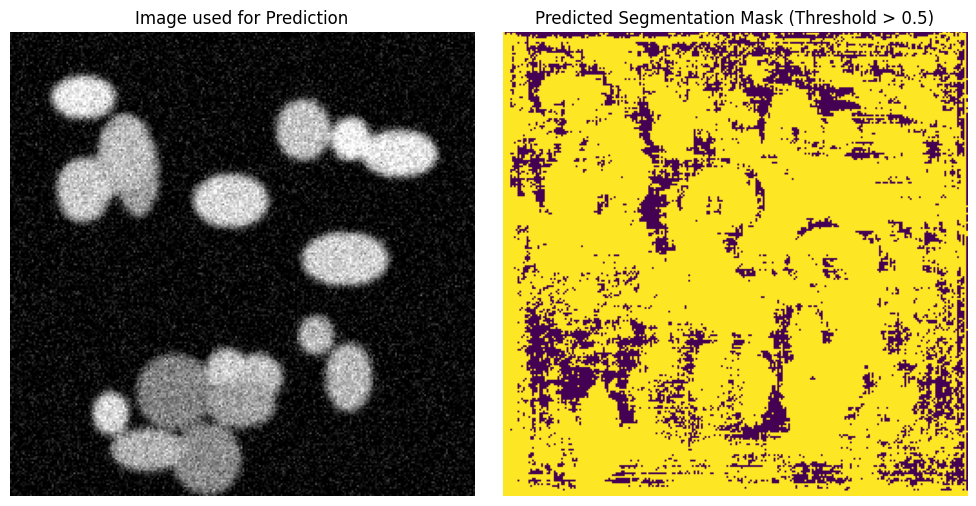

In [ ]:
# Run the Segment new images cell
# Select an image to segment. We will reuse the training image for demonstration.
# Preprocess the selected image.
# Convert to grayscale if necessary (already done in data prep, but good to include check)
if original_image.ndim == 3:
    if original_image.shape[-1] == 4:
        img_rgb = color.rgba2rgb(original_image)
    elif original_image.shape[-1] == 3:
        img_rgb = original_image
    else:
         raise ValueError(f"Unexpected number of channels: {original_image.shape[-1]}")
    img_gray_predict = color.rgb2gray(img_rgb)
    if img_gray_predict.dtype != np.uint8:
         img_gray_predict = (img_gray_predict * 255).astype(np.uint8)
else:
    img_gray_predict = original_image

# Resize to the target dimensions
resized_image_predict = resize(img_gray_predict, (IMG_HEIGHT, IMG_WIDTH), anti_aliasing=True)

# Normalize pixel values to the range [0, 1]
if resized_image_predict.max() > 1.0:
    normalized_image_predict = resized_image_predict / 255.0
else:
    normalized_image_predict = resized_image_predict

# Expand dimensions to (1, IMG_HEIGHT, IMG_WIDTH, 1) to match the model's input shape
X_predict = np.expand_dims(normalized_image_predict, axis=(0, -1)) # Add batch and channel dimensions

print(f"Input image shape for prediction: {X_predict.shape}")

# Use the trained unet_model to predict the segmentation mask
print("Predicting segmentation mask...")
predicted_mask_prob = unet_model.predict(X_predict)
print("Prediction complete.")

# Apply a threshold to the probability map to obtain a binary segmentation mask
threshold = 0.5
predicted_mask_binary = (predicted_mask_prob > threshold).astype(np.uint8)

# Remove the added batch and channel dimensions
final_predicted_mask = np.squeeze(predicted_mask_binary, axis=(0, -1))

print(f"Final predicted mask shape: {final_predicted_mask.shape}")

# Visualize the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(X_predict, axis=0), cmap='gray') # Squeeze batch dimension for display
plt.title('Image used for Prediction')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(final_predicted_mask, cmap='viridis')
plt.title(f'Predicted Segmentation Mask (Threshold > {threshold})')
plt.axis('off')

plt.tight_layout()
plt.show()

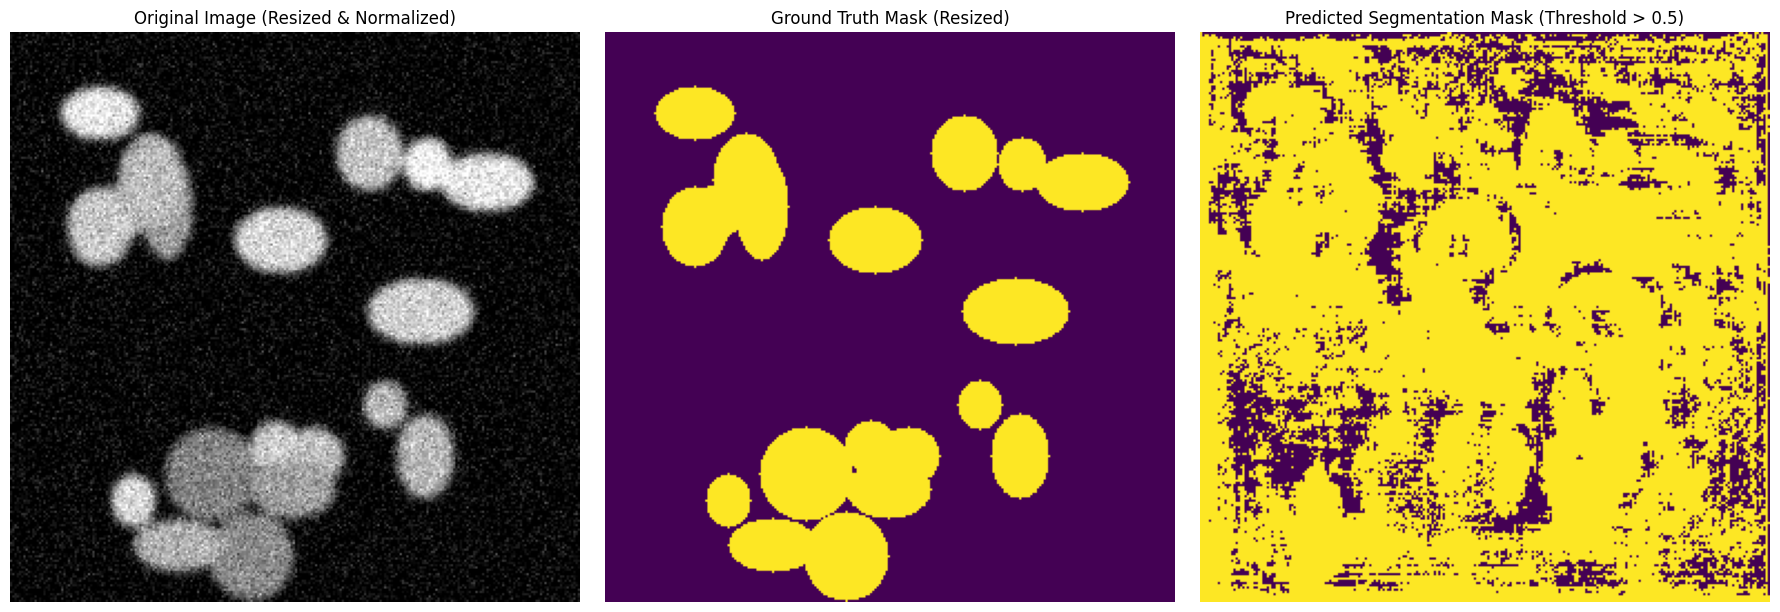

In [ ]:
# Run the Visualize results cell
# Visualize the results
# Use the variables X, y, and final_predicted_mask

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original Image (using the normalized, resized version X)
# X has shape (height, width, 1). Squeeze the channel dimension (-1).
axes[0].imshow(np.squeeze(X, axis=-1), cmap='gray')
axes[0].set_title('Original Image (Resized & Normalized)')
axes[0].axis('off')

# Ground Truth Mask (using the resized version y)
# y has shape (height, width, 1). Squeeze the channel dimension (-1).
axes[1].imshow(np.squeeze(y, axis=-1), cmap='viridis')
axes[1].set_title('Ground Truth Mask (Resized)')
axes[1].axis('off')

# Predicted Segmentation Mask
# final_predicted_mask has shape (height, width)
axes[2].imshow(final_predicted_mask, cmap='viridis')
axes[2].set_title(f'Predicted Segmentation Mask (Threshold > {threshold})')
axes[2].axis('off')

plt.tight_layout()
plt.show()